Author:Come Quintyn & Kathleen Guillet
University of Tartu

# Kaggle competition - Binary Prediction of Smoker Status using Bio-Signals


## Importing some libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns
plt.style.use('ggplot')

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Dataset for the competition


In [ ]:
from google.colab import files

files.upload(); # upload your data file

Saving XGB_Over.png to XGB_Over (1).png


## Setting up Kaggle

You need to have an account on Kaggle.com, before you proceed. When you access your kaggle profile, you need to download your API Token from kaggle. It's very easy:
1. Click on your profile icon
2. Go to **Account**
3. In **API** you press **Create new API token**

Now we load the file **kaggle.json** that you have downloaded, into this notebook:

In [ ]:
from google.colab import files

files.upload(); # upload your kaggle.json file

Saving RF_Under.png to RF_Under.png
Saving RF_Over.png to RF_Over.png


The next cell moves the file into a separate folder, sets secure access for it and configures your Kaggle profile for this notebook.

In [ ]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In order to sign up for the competition you need to accept the rules by cliking on "submission" button in the upper right corner: https://www.kaggle.com/competitions/playground-series-s3e24/overview

Make a test submission to ensure that the submission mechanism works

In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f sample_submission.csv -m "Message"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


Now you can check `My submissions` tab on the website: https://www.kaggle.com/competitions/playground-series-s3e24/submissions

## Read in the data

In [ ]:
train =  pd.read_csv('train.csv')

### Brief Exploratory Data Analysis (EDA)

In [ ]:
train.head()

In [ ]:
train.dtypes

id                       int64
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
smoking                  int64
dtype: object

In [ ]:
train.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


**texte en gras**### test set

In [ ]:
test = pd.read_csv('test.csv')
test_without_id=test.copy()
test_without_id.pop('id')
test.dtypes

id                       int64
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
dtype: object

In [ ]:
print(train.isnull().sum())

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64


In [ ]:
train.smoking.value_counts()

0    89603
1    69653
Name: smoking, dtype: int64

Text(0.5, 1.02, 'Scatter Plots of Features vs. smoking')

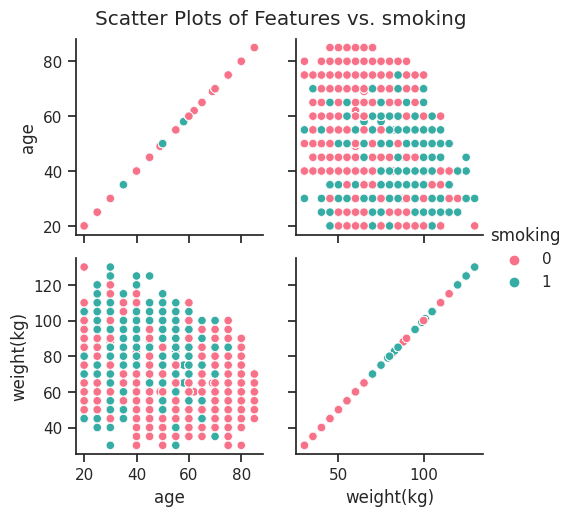

In [ ]:
features = ["age", "weight(kg)"]
sns.set(style="ticks")
g = sns.PairGrid(train[['age', 'weight(kg)', "smoking"]], vars=features, hue="smoking", palette="husl")
g.map(sns.scatterplot)
g.add_legend()
g.fig.suptitle("Scatter Plots of Features vs. smoking", y=1.02)

##Preparing the data


In [ ]:
# make a copy of the dataset
import copy
train_copy = copy.deepcopy(train.drop(columns = 'id'))
train_copy.pop('id')
test = copy.deepcopy(test)

In [ ]:
#balance data by oversampling
from imblearn.over_sampling import SMOTE
X_train= train_copy.drop(columns = 'smoking')
y_train= train_copy.smoking
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
train_overresampled = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns), pd.Series(y_resampled, name='smoking')], axis=1)

X_over = train_overresampled.drop(columns = 'smoking')
y_over = train_overresampled['smoking']
print(train_overresampled['smoking'].value_counts())

1    89603
0    89603
Name: smoking, dtype: int64


In [ ]:
train_X_over, val_X_over, train_y_over, val_y_over = train_test_split(X_over, y_over, random_state = 111, test_size = 0.20)

In [ ]:
#balance data by undersampling
from sklearn.utils import resample
class0=train[train['smoking']==0]
class1=train[train['smoking']==1]

negative_sample = class0.sample(len(class1), random_state=0)
positive_sample = class1

train_balanced = pd.concat([negative_sample, positive_sample])
print(train_balanced.smoking.value_counts())

train_copy=train_balanced
train_copy

0    69653
1    69653
Name: smoking, dtype: int64


In [ ]:
X_under = train_copy.drop('smoking', axis=1)
y_under = train_copy['smoking']

In [ ]:
train_X_under, val_X_under, train_y_under, val_y_under = train_test_split(X_under, y_under, random_state = 111, test_size = 0.20)

In [ ]:
#overundersampling method
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='auto')
X_train= train_copy.drop(columns = 'smoking')
y_train= train_copy.smoking
X_overunder, y_overunder = smt.fit_resample(X_train, y_train)

In [ ]:
y_overunder.value_counts()

0    58111
1    58111
Name: smoking, dtype: int64

In [ ]:
train_X_overunder, val_X_overunder, train_y_overunder, val_y_overunder = train_test_split(X_overunder, y_overunder, random_state = 111, test_size = 0.20)

In [ ]:
#PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X_over)
X_val_scaled = scaler.transform(val_X_over)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

##Tuning and training the models

###RandomForest

In [ ]:
#exemple to use the gridsearchCV method (taking ALL the training balanced data, not the one split with validation)
# can be really long to run, but give great results

param_grid = {
     'n_estimators': [225, 250],
     'max_depth': [30, 40],
     'min_samples_split': [4, 5],
     'min_samples_leaf': [1, 2],
     'max_features': ['sqrt', 'log2']
}

rfc = RandomForestClassifier()

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_over, y_over)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 225}
0.47747323155875565


Trying the same model but on the original dataset modified by various sampling methods

In [ ]:
#undersampling
rfc = RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4,
                             n_estimators = 255, random_state = 111)
rfc.fit(train_X_under, train_y_under)
y_pred = rfc.predict_proba(val_X_under)
acc = roc_auc_score(val_y_under, y_pred[:, 1])
acc

0.8581773012837967

In [ ]:
#oversampling
rfc_over = RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4,
                             n_estimators = 255, random_state = 111)
rfc_over.fit(train_X_over, train_y_over)
y_pred = rfc_over.predict_proba(val_X_over)
acc = roc_auc_score(val_y_over, y_pred[:, 1] )
acc

0.8861621544970043

In [ ]:
#overundersampling
rfc_overunder = RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4,
                             n_estimators = 255, random_state = 111)
rfc_overunder.fit(train_X_overunder, train_y_overunder)
y_pred = rfc_overunder.predict_proba(val_X_overunder)
acc = roc_auc_score(val_y_overunder, y_pred[:, 1] )
acc

0.8845771137023045

In [ ]:
#pca
rfc_pca = RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4,
                             n_estimators = 255, random_state = 111)
rfc_pca.fit(X_train_pca, train_y_over)
y_pred = rfc_pca.predict_proba(X_val_pca)
acc = roc_auc_score(val_y_over, y_pred[:, 1] )
acc

0.7730373436351202

We did better with oversampling and overundersampling.

Creating again the best model found and predict on the test set.

With oversampling data

In [ ]:
# create the model with the parameters print above, then fit and we can make a verification on the validation dataset. Finally predict on test set.
rfc = RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4,
                             n_estimators = 255, random_state = 111)

rfc.fit(X_over, y_over)
y_pred_rtc = rfc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
rfc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_rtc[:, 1]},
    columns = ['id', 'smoking'])
rfc_df.to_csv('randomForest.csv', index = False)

!ls

randomForest.csv  sample_data  sample_submission.csv  test.csv	train.csv


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f randomForest.csv -m "randomForestv"

100% 2.66M/2.66M [00:01<00:00, 2.21MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
!head randomForest.csv

id,smoking
159256,0.6464149639553999
159257,0.3397945845004669
159258,0.46215686274509804
159259,0.09704948646125117
159260,0.5017719813444508
159261,0.7629843801328252
159262,0.5697021238017289
159263,0.15265172735760973
159264,0.2538888888888889


In [ ]:
score_randomF = files.upload()

Saving Screenshot 2023-11-18 210819.png to Screenshot 2023-11-18 210819 (1).png


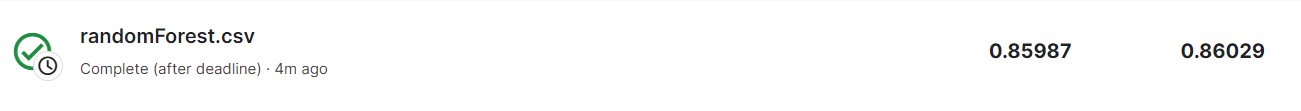

In [ ]:
from IPython.display import Image
Image(filename='RF_Over.png')

With undersampling data

In [ ]:
# create the model with the parameters print above, then fit and we can make a verification on the validation dataset. Finally predict on test set.
rfc = RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4,
                             n_estimators = 255, random_state = 111)

rfc.fit(X_under, y_under)
y_pred_rtc = rfc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
rfc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_rtc[:, 1]},
    columns = ['id', 'smoking'])
rfc_df.to_csv('randomForest_under.csv', index = False)

!ls

 randomForest_under.csv  'Screenshot 2023-12-06 122642.png'   train.csv
 sample_data		 'Screenshot 2023-12-06 122651.png'
 sample_submission.csv	  test.csv


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f randomForest_under.csv -m "randomForestv"

100% 2.66M/2.66M [00:01<00:00, 1.81MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_randomF = files.upload()

Saving Screenshot 2023-12-06 133246.png to Screenshot 2023-12-06 133246.png


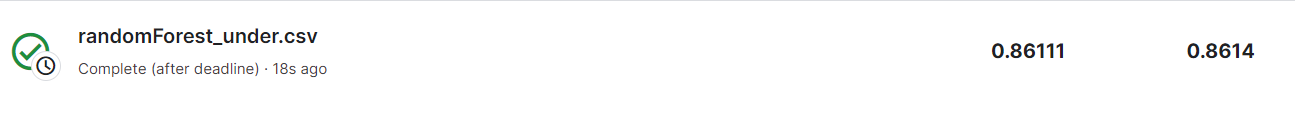

In [ ]:
from IPython.display import Image
Image(filename='RF_Under.png')

With overundersampling data

In [ ]:
# create the model with the parameters print above, then fit and we can make a verification on the validation dataset. Finally predict on test set.
rfc = RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4,
                             n_estimators = 255, random_state = 111)

rfc.fit(X_overunder, y_overunder)
y_pred_rtc = rfc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
rfc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_rtc[:, 1]},
    columns = ['id', 'smoking'])
rfc_df.to_csv('randomForest_overunder.csv', index = False)

!ls

 randomForest_overunder.csv   sample_submission.csv		 'Screenshot 2023-12-06 133246.png'
 randomForest_under.csv      'Screenshot 2023-12-06 122642.png'   test.csv
 sample_data		     'Screenshot 2023-12-06 122651.png'   train.csv


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f randomForest_overunder.csv -m "randomForestv"

100% 2.66M/2.66M [00:01<00:00, 1.94MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_randomF = files.upload()

Saving Screenshot 2023-12-06 133531.png to Screenshot 2023-12-06 133531.png


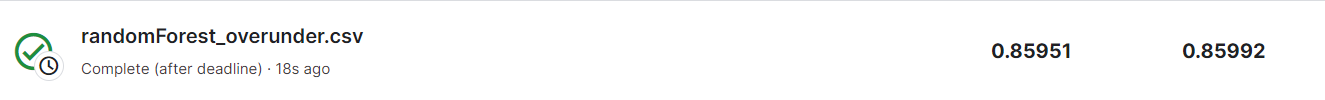

In [ ]:
from IPython.display import Image
Image(filename='RF_OverUnder.png')

###XGBoost

In [ ]:
import warnings
warnings.filterwarnings("ignore")

dtrain = xgb.DMatrix(train_X_over, label=train_y_over)
dval = xgb.DMatrix(val_X_over, label=val_y_over)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 5,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1,
    "alpha": 0.1,
    "eta": 0.1,
    "early_stopping_rounds": 10,
    "num_boost_round": 160
}

bst = xgb.train(params, dtrain, num_boost_round=params["num_boost_round"], evals=[(dtrain, "train"), (dval, "val")], early_stopping_rounds=params["early_stopping_rounds"])

y_pred = bst.predict(dval)
auc = roc_auc_score(val_y_over, (y_pred > 0.5).astype(int))
auc



[0]	train-logloss:0.65854	val-logloss:0.65813
[1]	train-logloss:0.63016	val-logloss:0.62937
[2]	train-logloss:0.60652	val-logloss:0.60549
[3]	train-logloss:0.58981	val-logloss:0.58866
[4]	train-logloss:0.57249	val-logloss:0.57109
[5]	train-logloss:0.55809	val-logloss:0.55649
[6]	train-logloss:0.54484	val-logloss:0.54315
[7]	train-logloss:0.53372	val-logloss:0.53197
[8]	train-logloss:0.52364	val-logloss:0.52180
[9]	train-logloss:0.51482	val-logloss:0.51282
[10]	train-logloss:0.50732	val-logloss:0.50519
[11]	train-logloss:0.50065	val-logloss:0.49842
[12]	train-logloss:0.49499	val-logloss:0.49263
[13]	train-logloss:0.48953	val-logloss:0.48719
[14]	train-logloss:0.48495	val-logloss:0.48266
[15]	train-logloss:0.48040	val-logloss:0.47799
[16]	train-logloss:0.47679	val-logloss:0.47429
[17]	train-logloss:0.47335	val-logloss:0.47094
[18]	train-logloss:0.47023	val-logloss:0.46786
[19]	train-logloss:0.46708	val-logloss:0.46465
[20]	train-logloss:0.46417	val-logloss:0.46172
[21]	train-logloss:0.46

0.8065696622936945

In [ ]:
dtest = xgb.DMatrix(test, enable_categorical = True)
y_pred_xgb =bst.predict(dtest)

In [ ]:
y_pred_xgb

array([0.64452267, 0.18275921, 0.39871103, ..., 0.49032623, 0.12545869,
       0.03152043], dtype=float32)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
xgb_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_xgb},
    columns = ['id', 'smoking'])
xgb_df.to_csv('XGBoost.csv', index = False)

!ls

randomForest.csv  sample_data  sample_submission.csv  test.csv	train.csv  XGBoost.csv


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f XGBoost.csv -m "XGBoost"

100% 1.80M/1.80M [00:01<00:00, 1.72MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_XGB = files.upload()

Saving Screenshot 2023-12-05 165229.png to Screenshot 2023-12-05 165229.png


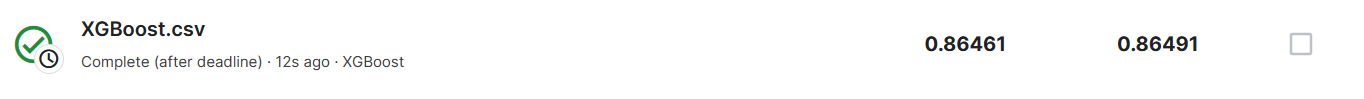

In [ ]:
from IPython.display import Image
Image(filename='Screenshot 2023-12-05 165229.png')

XGBoost is trained very quickly and gave us good result at the end. It is then a great model if we want good score in fewer time.

###XGBClassifier

In [ ]:
param_grid = {
    'learning_rate': [0.075, 0.1, 0.12],
    'n_estimators': [175, 185],
    'max_depth': [4, 5, 6],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.85],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 2],
    'lambda': [0, 0.5],
    'alpha': [0.7, 1],
    'scale_pos_weight': [1, 2],
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss']
}

xgbc = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgbc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_over, y_over)

results_df = pd.DataFrame(grid_search.cv_results_)
for i in range(results_df.shape[0]):
    params = results_df.loc[i, 'params']
    mean_score = results_df.loc[i, 'mean_test_score']
    print(f"Iteration {i + 1} - AUC Score: {mean_score:.4f}")

print(grid_search.best_params_)
print(grid_search.best_score_)

final_xgbc = grid_search.best_estimator_

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7adf16d1b970>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 588, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


In [ ]:
xgbc = XGBClassifier(alpha = 1, colsample_bytree = 0.8, eval_metric = 'logloss', gamma = 0.2, learning_rate = 0.1, max_depth = 5, min_child_weight = 1,
                     n_estimators = 175, objective = 'binary:logistic', scale_pos_weight = 1, subsample = 0.8, random_state = 42)

xgbc.fit(train_X_over, train_y_over)
y_pred_xgbc = xgbc.predict_proba(val_X_over)
acc = roc_auc_score(val_y_over, y_pred_xgbc[:, 1])
acc

0.8965504695187088

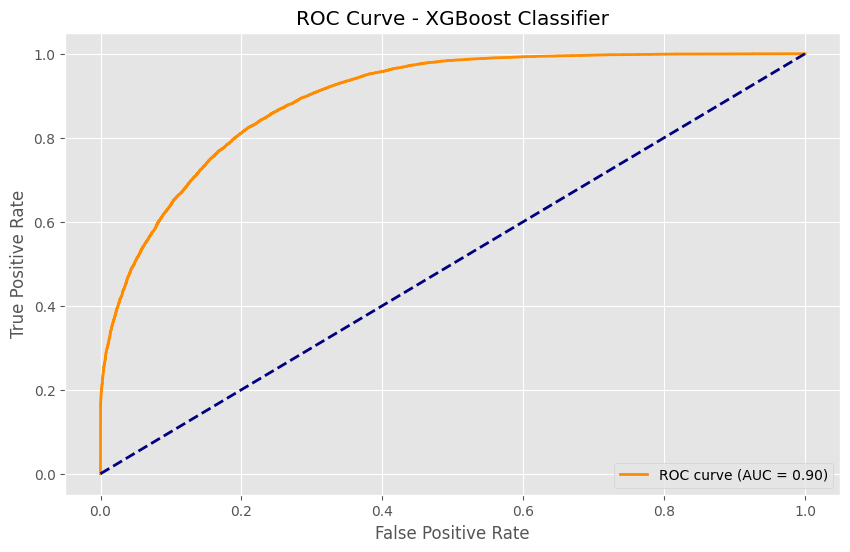

Area under the ROC curve (AUC): 0.90


In [ ]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(val_y_over, y_pred_xgbc[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()

# Display the AUC score
print('Area under the ROC curve (AUC): {:.2f}'.format(roc_auc))

In [ ]:
xgbc = XGBClassifier(alpha = 1, colsample_bytree = 0.8, eval_metric = 'logloss', gamma = 0.2, learning_rate = 0.1, max_depth = 5, min_child_weight = 1,
                     n_estimators = 175, objective = 'binary:logistic', scale_pos_weight = 1, subsample = 0.8, random_state = 42)

xgbc.fit(train_X_under, train_y_under)
y_pred_xgbc = xgbc.predict_proba(val_X_under)
acc = roc_auc_score(val_y_under, y_pred_xgbc[:, 1])
acc

0.8658915303473095

With oversampling dataset

In [ ]:
xgbc = XGBClassifier(alpha = 1, colsample_bytree = 0.8, eval_metric = 'logloss', gamma = 0.2, learning_rate = 0.1, max_depth = 5, min_child_weight = 1,
                     n_estimators = 175, objective = 'binary:logistic', scale_pos_weight = 1, subsample = 0.8, random_state = 42)

xgbc.fit(X_over, y_over)
y_pred_xgbc = xgbc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
xgbc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_xgbc[:, 1]},
    columns = ['id', 'smoking'])
xgbc_df.to_csv('XGBoostClassifier.csv', index = False)

!ls

sample_data	       test.csv   XGBoostClassifier_overunder.csv
sample_submission.csv  train.csv  XGBoostClassifier_under.csv


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f XGBoostClassifier.csv -m "XGBoostClassifier"

100% 1.81M/1.81M [00:00<00:00, 2.85MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_XGBC = files.upload()

Saving Screenshot 2023-11-18 211240.png to Screenshot 2023-11-18 211240.png


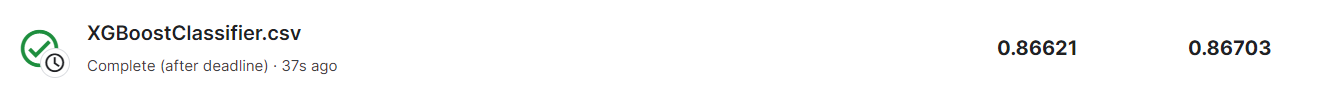

In [ ]:
from IPython.display import Image
Image(filename='XGB_Over.png')

With undersampling dataset

In [ ]:
xgbc = XGBClassifier(alpha = 1, colsample_bytree = 0.8, eval_metric = 'logloss', gamma = 0.2, learning_rate = 0.1, max_depth = 5, min_child_weight = 1,
                     n_estimators = 175, objective = 'binary:logistic', scale_pos_weight = 1, subsample = 0.8, random_state = 42)

xgbc.fit(X_under, y_under)
y_pred_xgbc = xgbc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
xgbc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_xgbc[:, 1]},
    columns = ['id', 'smoking'])
xgbc_df.to_csv('XGBoostClassifier_under.csv', index = False)

!ls

sample_data	       test.csv   XGBoostClassifier_overunder.csv
sample_submission.csv  train.csv  XGBoostClassifier_under.csv


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f XGBoostClassifier_under.csv -m "XGBoostClassifier"

100% 1.81M/1.81M [00:00<00:00, 2.85MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_XGBC = files.upload()

Saving Screenshot 2023-12-06 122642.png to Screenshot 2023-12-06 122642.png


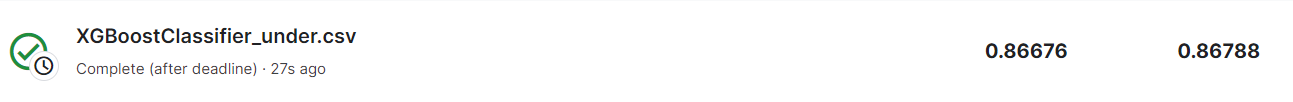

In [ ]:
from IPython.display import Image
Image(filename='XGB_Under.png')

With overundersampling

In [ ]:
xgbc = XGBClassifier(alpha = 1, colsample_bytree = 0.8, eval_metric = 'logloss', gamma = 0.2, learning_rate = 0.1, max_depth = 5, min_child_weight = 1,
                     n_estimators = 175, objective = 'binary:logistic', scale_pos_weight = 1, subsample = 0.8, random_state = 42)

xgbc.fit(X_overunder, y_overunder)
y_pred_xgbc = xgbc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
xgbc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_xgbc[:, 1]},
    columns = ['id', 'smoking'])
xgbc_df.to_csv('XGBoostClassifier_overunder.csv', index = False)

!ls

sample_data	       test.csv   XGBoostClassifier_overunder.csv
sample_submission.csv  train.csv  XGBoostClassifier_under.csv


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f XGBoostClassifier_overunder.csv -m "XGBoostClassifier"

100% 1.81M/1.81M [00:00<00:00, 2.85MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_XGBC = files.upload()

Saving Screenshot 2023-12-06 122651.png to Screenshot 2023-12-06 122651.png


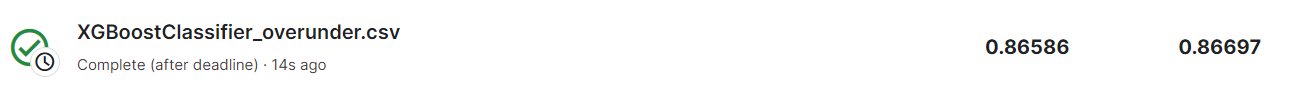

In [ ]:
from IPython.display import Image
Image(filename='XGB_OverUnder.png')

The best result for all models.

###GradientBoostingClassifier

In [ ]:
param_grid = {
    'n_estimators': [200, 250],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [ 5, 7],
    'min_samples_split': [3, 4, 6],
    'min_samples_leaf': [3, 6],
    'subsample': [0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}
gbc = GradientBoostingClassifier()
grid_search = GridSearchCV(gbc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(train_X_over, train_y_over)

print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, max_features = 'sqrt',
                                 min_samples_leaf = 6, min_samples_split = 5, n_estimators = 260, subsample = 1.0)

gbc.fit(train_X_over, train_y_over)
y_pred_gbc = gbc.predict_proba(val_X_over)
acc = roc_auc_score(val_y_over, y_pred_gbc[:, 1])
acc

0.8973288314939187

With oversampling data

In [ ]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, max_features = 'sqrt',
                                 min_samples_leaf = 6, min_samples_split = 5, n_estimators = 260, subsample = 1.0)
gbc.fit(X_over, y_over)
y_pred_gbc = gbc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
gbc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_gbc[:, 1]},
    columns = ['id', 'smoking'])
gbc_df.to_csv('GradientBoostClassifier.csv', index = False)

!ls

 GradientBoostClassifier.csv  'Screenshot 2023-11-18 210819 (1).png'   train.csv
 playground-series-s3e24.zip  'Screenshot 2023-11-18 210819.png'       XGBoostClassifier.csv
 sample_data		      'Screenshot 2023-11-18 211240.png'
 sample_submission.csv	       test.csv


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f GradientBoostClassifier.csv -m "GradientBoostClassifier"

100% 2.67M/2.67M [00:02<00:00, 1.12MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_GBC = files.upload()

Saving Screenshot 2023-11-18 213357.png to Screenshot 2023-11-18 213357.png


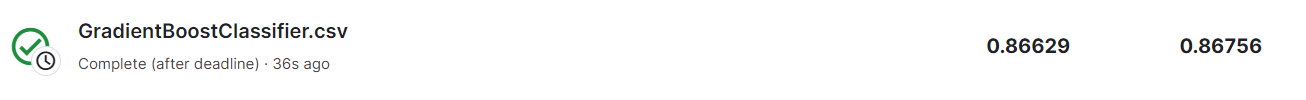

In [ ]:
from IPython.display import Image
Image(filename='GB_Over.png')

With undersampling data

In [ ]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, max_features = 'sqrt',
                                 min_samples_leaf = 6, min_samples_split = 5, n_estimators = 260, subsample = 1.0)
gbc.fit(X_under, y_under)
y_pred_gbc = gbc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
gbc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_gbc[:, 1]},
    columns = ['id', 'smoking'])
gbc_df.to_csv('GradientBoostClassifier_under.csv', index = False)

!ls

 GradientBoostClassifier_under.csv  'Screenshot 2023-12-06 122651.png'
 randomForest_overunder.csv	    'Screenshot 2023-12-06 133246.png'
 randomForest_under.csv		    'Screenshot 2023-12-06 133531.png'
 sample_data			     test.csv
 sample_submission.csv		     train.csv
'Screenshot 2023-12-06 122642.png'


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f GradientBoostClassifier_under.csv -m "GradientBoostClassifier"

100% 2.67M/2.67M [00:01<00:00, 1.90MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_GBC = files.upload()

Saving Screenshot 2023-12-06 133835.png to Screenshot 2023-12-06 133835.png


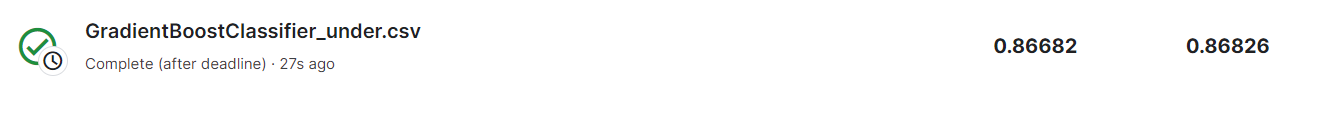

In [ ]:
from IPython.display import Image
Image(filename='GB_Under.png')

With overundersampling

In [ ]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, max_features = 'sqrt',
                                 min_samples_leaf = 6, min_samples_split = 5, n_estimators = 260, subsample = 1.0)
gbc.fit(X_overunder, y_overunder)
y_pred_gbc = gbc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
gbc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_gbc[:, 1]},
    columns = ['id', 'smoking'])
gbc_df.to_csv('GradientBoostClassifier_overunder.csv', index = False)

!ls

 GradientBoostClassifier_overunder.csv	'Screenshot 2023-12-06 122651.png'
 GradientBoostClassifier_under.csv	'Screenshot 2023-12-06 133246.png'
 randomForest_overunder.csv		'Screenshot 2023-12-06 133531.png'
 randomForest_under.csv			'Screenshot 2023-12-06 133835.png'
 sample_data				 test.csv
 sample_submission.csv			 train.csv
'Screenshot 2023-12-06 122642.png'


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f GradientBoostClassifier_overunder.csv -m "GradientBoostClassifier"

100% 2.69M/2.69M [00:01<00:00, 1.60MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_GBC = files.upload()

Saving Screenshot 2023-12-06 134028.png to Screenshot 2023-12-06 134028.png


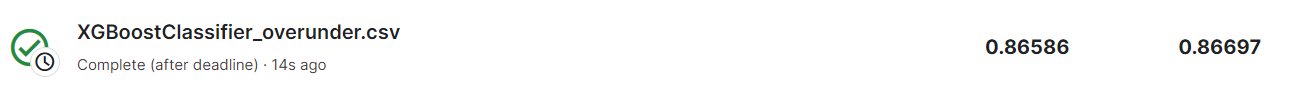

In [ ]:
from IPython.display import Image
Image(filename='XGB_OverUnder.png')

###AdaBoost

In [ ]:
param_grid = {
    'n_estimators': [200, 250],
    'learning_rate': [0.01, 0.1, 0.2],
    'base_estimator__max_depth': [ 5, 8],
}

base_model = DecisionTreeClassifier()
abc = AdaBoostClassifier(base_model)
grid_search = GridSearchCV(abc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(train_X_over, train_y_over)

print(grid_search.best_params_)
print(grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
/usr/local/lib/python3.10/dist-packages/

{'base_estimator__max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200}
0.8884434949794144


In [ ]:
base_model = DecisionTreeClassifier(max_depth = 5)
abc = AdaBoostClassifier(base_model, learning_rate = 0.1, n_estimators = 200)

abc.fit(train_X_over, train_y_over)
y_pred_abc = abc.predict_proba(val_X_over)
acc = roc_auc_score(val_y_over, y_pred_abc[:, 1])
acc

0.8939438265264474

With oversampling data

In [ ]:
base_model = DecisionTreeClassifier(max_depth = 5)
abc = AdaBoostClassifier(base_model, learning_rate = 0.1, n_estimators = 200)

abc.fit(X_over, y_over)
y_pred_abc = abc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
abc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_abc[:, 1]},
    columns = ['id', 'smoking'])
abc_df.to_csv('AdaBoostClassifier.csv', index = False)

!ls

AdaBoostClassifier.csv	     sample_data	    test.csv
playground-series-s3e24.zip  sample_submission.csv  train.csv


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f AdaBoostClassifier.csv -m "AdaBoostClassifier"

100% 2.65M/2.65M [00:02<00:00, 1.11MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_ABC = files.upload()

Saving Screenshot 2023-11-19 181028.png to Screenshot 2023-11-19 181028.png


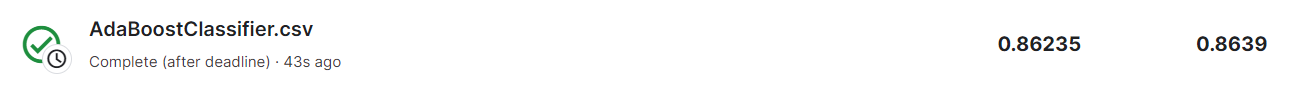

In [ ]:
from IPython.display import Image
Image(filename='ADA_Over.png')

With undersampling data

In [ ]:
base_model = DecisionTreeClassifier(max_depth = 5)
abc = AdaBoostClassifier(base_model, learning_rate = 0.1, n_estimators = 200)

abc.fit(X_under, y_under)
y_pred_abc = abc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
abc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_abc[:, 1]},
    columns = ['id', 'smoking'])
abc_df.to_csv('AdaBoostClassifier_under.csv', index = False)

!ls

 AdaBoostClassifier_under.csv		'Screenshot 2023-12-06 122651.png'
 GradientBoostClassifier_overunder.csv	'Screenshot 2023-12-06 133246.png'
 GradientBoostClassifier_under.csv	'Screenshot 2023-12-06 133531.png'
 randomForest_overunder.csv		'Screenshot 2023-12-06 133835.png'
 randomForest_under.csv			'Screenshot 2023-12-06 134028.png'
 sample_data				 test.csv
 sample_submission.csv			 train.csv
'Screenshot 2023-12-06 122642.png'


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f AdaBoostClassifier_under.csv -m "AdaBoostClassifier"

100% 2.64M/2.64M [00:01<00:00, 1.95MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_ABC = files.upload()

Saving Screenshot 2023-12-06 134616.png to Screenshot 2023-12-06 134616.png


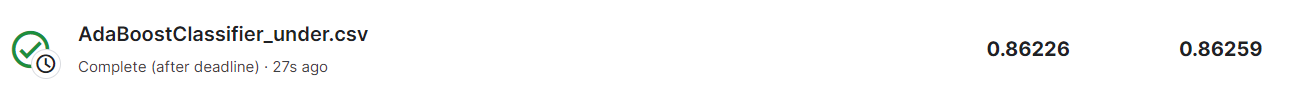

In [ ]:
from IPython.display import Image
Image(filename='ADA_Under.png')

With overundersampling data

In [ ]:
base_model = DecisionTreeClassifier(max_depth = 5)
abc = AdaBoostClassifier(base_model, learning_rate = 0.1, n_estimators = 200)

abc.fit(X_overunder, y_overunder)
y_pred_abc = abc.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
abc_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_abc[:, 1]},
    columns = ['id', 'smoking'])
abc_df.to_csv('AdaBoostClassifier_overunder.csv', index = False)

!ls

 AdaBoostClassifier_overunder.csv	'Screenshot 2023-12-06 122651.png'
 AdaBoostClassifier_under.csv		'Screenshot 2023-12-06 133246.png'
 GradientBoostClassifier_overunder.csv	'Screenshot 2023-12-06 133531.png'
 GradientBoostClassifier_under.csv	'Screenshot 2023-12-06 133835.png'
 randomForest_overunder.csv		'Screenshot 2023-12-06 134028.png'
 randomForest_under.csv			'Screenshot 2023-12-06 134616.png'
 sample_data				 test.csv
 sample_submission.csv			 train.csv
'Screenshot 2023-12-06 122642.png'


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f AdaBoostClassifier_overunder.csv -m "AdaBoostClassifier"

100% 2.64M/2.64M [00:01<00:00, 1.68MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_ABC = files.upload()

Saving Screenshot 2023-12-06 135011.png to Screenshot 2023-12-06 135011.png


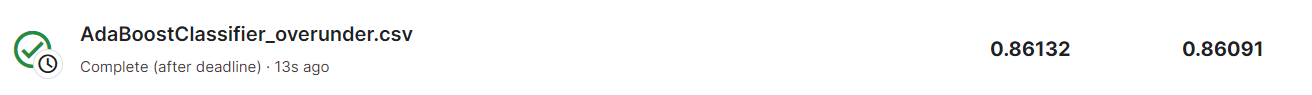

In [ ]:
from IPython.display import Image
Image(filename='ADA_OverUnder.png')

###KNN

With oversampling data

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 9, p = 1, weights = 'distance')

knn.fit(X_over, y_over)
y_pred_knn = knn.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
knn_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_knn[:, 1]},
    columns = ['id', 'smoking'])
knn_df.to_csv('KNeighborsClassifier.csv', index = False)

!ls

 AdaBoostClassifier_overunder.csv	'Screenshot 2023-12-06 122651.png'
 AdaBoostClassifier_under.csv		'Screenshot 2023-12-06 133246.png'
 GradientBoostClassifier_overunder.csv	'Screenshot 2023-12-06 133531.png'
 GradientBoostClassifier_under.csv	'Screenshot 2023-12-06 133835.png'
 KNeighborsClassifier.csv		'Screenshot 2023-12-06 134028.png'
 randomForest_overunder.csv		'Screenshot 2023-12-06 134616.png'
 randomForest_under.csv			'Screenshot 2023-12-06 135011.png'
 sample_data				 test.csv
 sample_submission.csv			 train.csv
'Screenshot 2023-12-06 122642.png'


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f KNeighborsClassifier.csv -m "KNeighborsClassifier"

100% 2.61M/2.61M [00:01<00:00, 1.86MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_KNN = files.upload()

Saving Screenshot 2023-12-06 152107.png to Screenshot 2023-12-06 152107.png


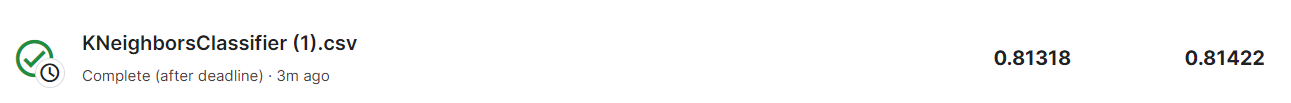

In [ ]:
from IPython.display import Image
Image(filename='KNN_Over.png')

With undersampling data

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 9, p = 1, weights = 'distance')

knn.fit(X_under, y_under)
y_pred_knn = knn.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
knn_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_knn[:, 1]},
    columns = ['id', 'smoking'])
knn_df.to_csv('KNeighborsClassifier_under.csv', index = False)

!ls

 AdaBoostClassifier_overunder.csv	'Screenshot 2023-12-06 122651.png'
 AdaBoostClassifier_under.csv		'Screenshot 2023-12-06 133246.png'
 GradientBoostClassifier_overunder.csv	'Screenshot 2023-12-06 133531.png'
 GradientBoostClassifier_under.csv	'Screenshot 2023-12-06 133835.png'
 KNeighborsClassifier.csv		'Screenshot 2023-12-06 134028.png'
 KNeighborsClassifier_under.csv		'Screenshot 2023-12-06 134616.png'
 randomForest_overunder.csv		'Screenshot 2023-12-06 135011.png'
 randomForest_under.csv			'Screenshot 2023-12-06 152107.png'
 sample_data				 test.csv
 sample_submission.csv			 train.csv
'Screenshot 2023-12-06 122642.png'


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f KNeighborsClassifier_under.csv -m "KNeighborsClassifier"

100% 2.64M/2.64M [00:01<00:00, 1.84MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_KNN = files.upload()

Saving Screenshot 2023-12-06 153151.png to Screenshot 2023-12-06 153151.png


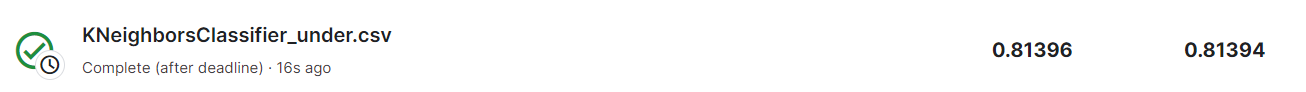

In [ ]:
from IPython.display import Image
Image(filename='KNN_Under.png')

With overundersampling data

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 9, p = 1, weights = 'distance')

knn.fit(X_overunder, y_overunder)
y_pred_knn = knn.predict_proba(test_without_id)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
knn_df = pd.DataFrame(
    {'id': test.id, 'smoking': y_pred_knn[:, 1]},
    columns = ['id', 'smoking'])
knn_df.to_csv('KNeighborsClassifier_overunder.csv', index = False)

!ls

 AdaBoostClassifier_overunder.csv	'Screenshot 2023-12-06 122651.png'
 AdaBoostClassifier_under.csv		'Screenshot 2023-12-06 133246.png'
 GradientBoostClassifier_overunder.csv	'Screenshot 2023-12-06 133531.png'
 GradientBoostClassifier_under.csv	'Screenshot 2023-12-06 133835.png'
 KNeighborsClassifier.csv		'Screenshot 2023-12-06 134028.png'
 KNeighborsClassifier_overunder.csv	'Screenshot 2023-12-06 134616.png'
 KNeighborsClassifier_under.csv		'Screenshot 2023-12-06 135011.png'
 randomForest_overunder.csv		'Screenshot 2023-12-06 152107.png'
 randomForest_under.csv			'Screenshot 2023-12-06 153151.png'
 sample_data				 test.csv
 sample_submission.csv			 train.csv
'Screenshot 2023-12-06 122642.png'


In [ ]:
!kaggle competitions submit -c playground-series-s3e24 -f KNeighborsClassifier_overunder.csv -m "KNeighborsClassifier"

100% 2.64M/2.64M [00:01<00:00, 1.88MB/s]
Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals

In [ ]:
score_KNN = files.upload()

Saving Screenshot 2023-12-06 154335.png to Screenshot 2023-12-06 154335.png


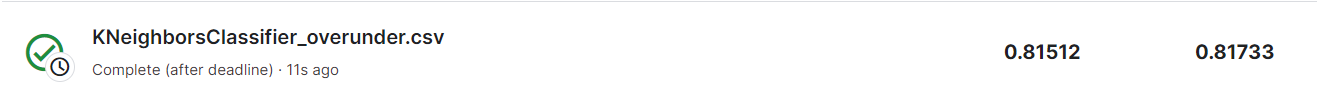

In [ ]:
from IPython.display import Image
Image(filename='KNN_OverUnder.png')

##Summarizing the results

In [ ]:
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'AdaBoost', 'KNN']
scores = [0.858,  0.866, 0.860, 0.849, 0.81418]

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, scores, color=['blue', 'green', 'orange', 'red','purple'])
plt.title('Model Comparison - score')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0.8, 1)
plt.show()

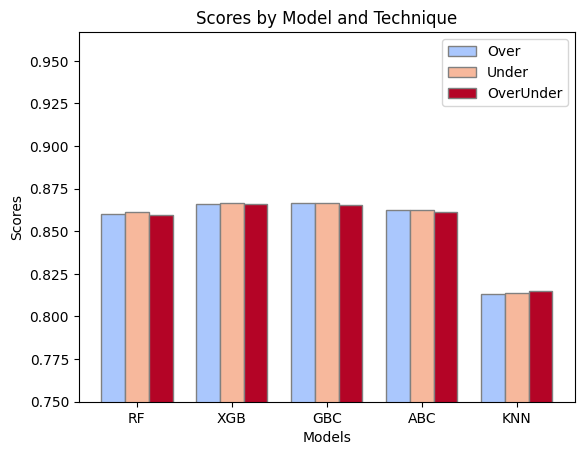

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
models = ['RF', 'XGB', 'GBC', 'ABC', 'KNN']
over = [0.85987, 0.86621, 0.86629, 0.86235, 0.81318]
under = [0.86111, 0.86676, 0.86682, 0.86226, 0.81396]
overunder = [0.85951, 0.86586, 0.86551, 0.86132, 0.81512]

bar_width = 0.25
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

coolwarm_colors = plt.cm.coolwarm(np.linspace(0, 1, 4))
fig = plt.figure(facecolor='white')
plt.bar(r1, over, color=coolwarm_colors[1], width=bar_width, edgecolor='grey', label='Over')
plt.bar(r2, under, color=coolwarm_colors[2], width=bar_width, edgecolor='grey', label='Under')
plt.bar(r3, overunder, color=coolwarm_colors[3], width=bar_width, edgecolor='grey', label='OverUnder')

plt.xlabel('Models')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylabel('Scores')
plt.title('Scores by Model and Technique')
plt.legend()
plt.ylim(0.75, max(max(over), max(under), max(overunder)) + 0.1)
plt.grid(False)
plt.savefig('heatmap.svg', format='svg', bbox_inches='tight')
plt.show()


## Analizing the Data

###Correlation circle

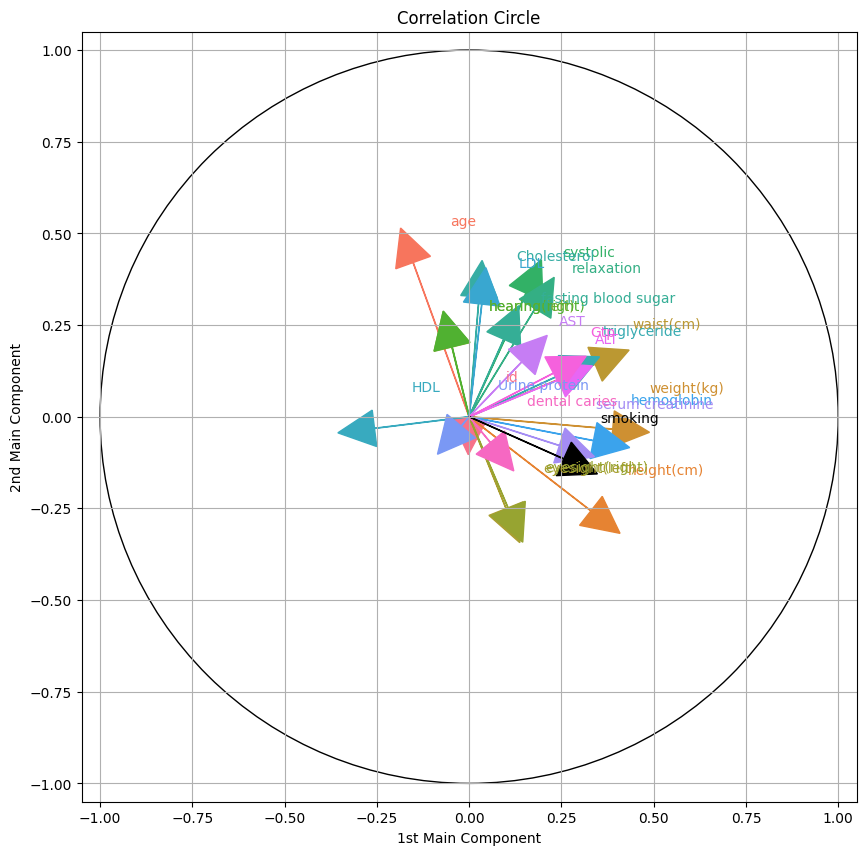

In [ ]:
#TODO
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

columns=train.columns
L_columns=[]
for column in columns:
  L_columns.append(column)

variables=train[L_columns]
#print(variables)
#Reduce and center the variables which is necesary for an PCA
scaler=StandardScaler()
variables_centrees_reduites=scaler.fit_transform(variables)

#Create the PCA
acp=PCA()
acp.fit(variables_centrees_reduites)

#Create a correlation circle
fig,ax=plt.subplots(figsize=(10,10))
#ACP_components is the coordinate of each variable(columnes) according to each components(rows).
#(also how much data is explained be each main components)
variables_actives=acp.components_
n_variables=len(variables.columns)

#for i in range(n_variables):
#    name_column=L_columns[i]
#    if name_column == 'smoking':
#        ax.arrow(0, 0, variables_actives[0, i], variables_actives[1, i], head_width=0.1, head_length=0.1, fc='k', ec='k')
#        ax.text(variables_actives[0, i] + 0.1, variables_actives[1, i] + 0.1, name_column, color='k')
#
#    else:
#      ax.arrow(0, 0, variables_actives[0, i], variables_actives[1, i], head_width=0.1, head_length=0.1, fc='r', ec='r')
#      ax.text(variables_actives[0, i] + 0.1, variables_actives[1, i] + 0.1, name_column, color='b')

palette = sns.color_palette("husl", n_colors=n_variables)
colors = [palette[i] for i in range(n_variables)]
for i in range(n_variables):
    name_column = L_columns[i]
    if name_column == 'smoking':
      ax.arrow(0, 0, variables_actives[0, i], variables_actives[1, i], head_width=0.1, head_length=0.1, fc='k', ec='k')
      ax.text(variables_actives[0, i] + 0.1, variables_actives[1, i] + 0.1, name_column, color='k')
    else:
      ax.arrow(0, 0, variables_actives[0, i], variables_actives[1, i], head_width=0.1, head_length=0.1, fc=colors[i], ec=colors[i])
      ax.text(variables_actives[0, i] + 0.1, variables_actives[1, i] + 0.1, name_column, color=colors[i])


#Add a circle
circle = plt.Circle((0, 0), 1, fill=False, color='black')
ax.add_patch(circle)

ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_xlabel('1st Main Component')
ax.set_ylabel('2nd Main Component')
ax.set_title('Correlation Circle')
plt.grid(True)
plt.show()
plt.close()

In [ ]:
sorted(train['age'].unique())

[20, 25, 30, 35, 40, 45, 49, 50, 55, 58, 60, 62, 65, 69, 70, 75, 80, 85]

Age in negatively correlated with smoking, this is normal, people who smokes die at an earlier age.

###Correlation Matrix

In [ ]:
correlation_matrix = train.corr()
correlation_with_target = correlation_matrix['smoking']

In [ ]:
correlation_with_target

id                    -0.000632
age                   -0.206033
height(cm)             0.447111
weight(kg)             0.351748
waist(cm)              0.262715
eyesight(left)         0.100420
eyesight(right)        0.109781
hearing(left)         -0.038219
hearing(right)        -0.036858
systolic               0.058642
relaxation             0.109501
fasting blood sugar    0.096534
Cholesterol           -0.051896
triglyceride           0.331975
HDL                   -0.271186
LDL                   -0.072285
hemoglobin             0.450679
Urine protein         -0.028548
serum creatinine       0.272979
AST                    0.059394
ALT                    0.163016
Gtp                    0.305561
dental caries          0.106636
smoking                1.000000
Name: smoking, dtype: float64

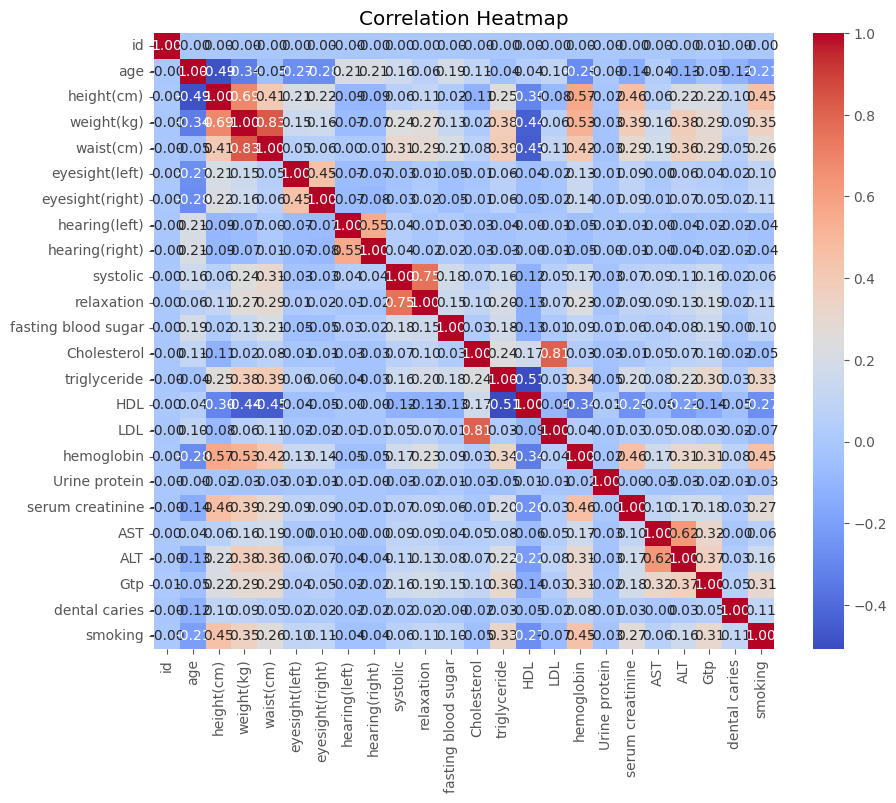

In [ ]:
# Heatmap of Correlation
correlation_matrix = train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

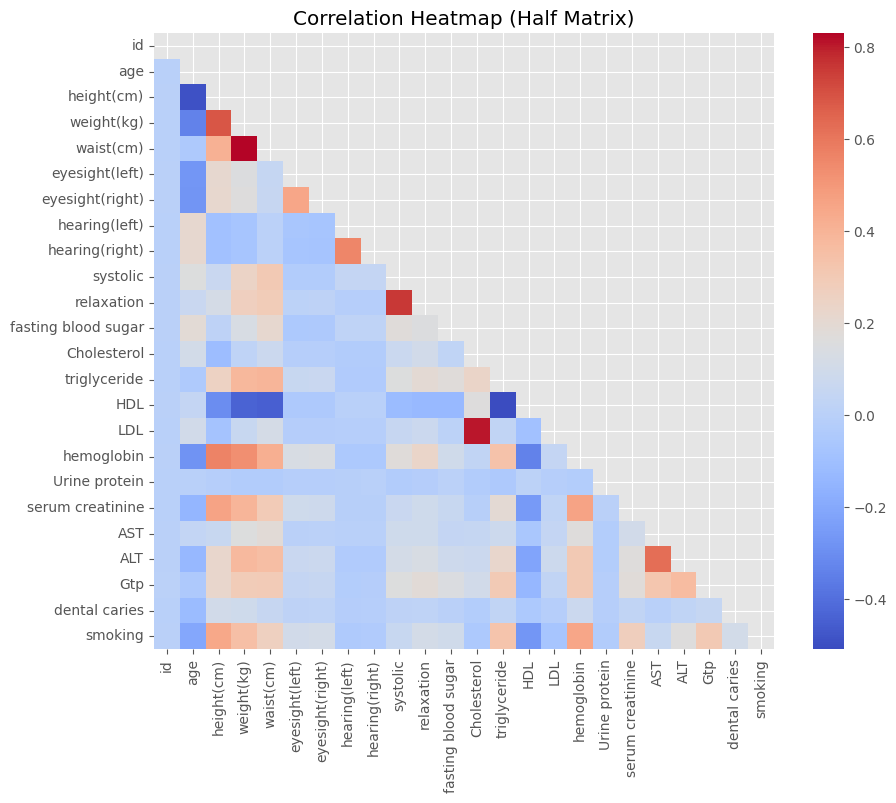

In [ ]:
correlation_matrix = train.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_matrix = correlation_matrix.mask(mask)
correlation_matrix = correlation_matrix.replace(0, np.nan)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", cbar_kws={'label': ''})
plt.title("Correlation Heatmap (Half Matrix)")
plt.savefig('Correlationheatmap.svg', format='svg', bbox_inches='tight')
plt.show()

###Distribution plot of features

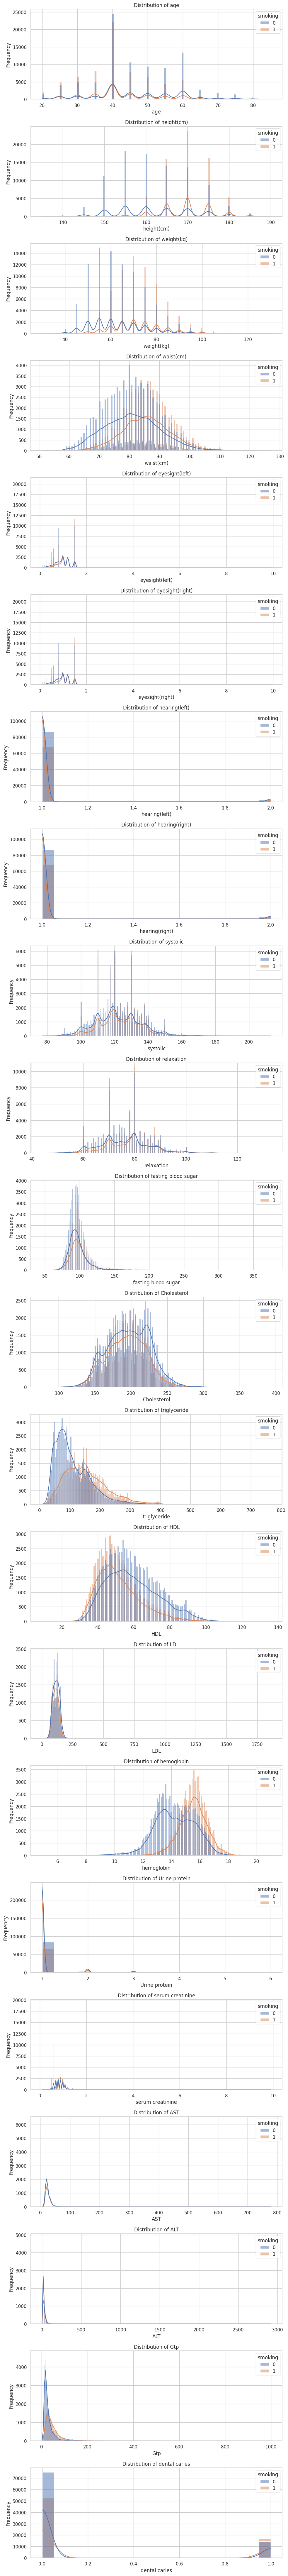

In [ ]:
# Distribution Plots of Features
features_to_plot = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
                    'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
                    'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
                    'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine',
                    'AST', 'ALT', 'Gtp', 'dental caries']

sns.set(style="whitegrid")
num_plots = len(features_to_plot)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 4 * num_plots))

# Loop through each feature and create distribution plots
for i, feature in enumerate(features_to_plot):
    sns.histplot(data=train, x=feature, hue='smoking', kde=True, ax=axes[i], common_norm=False)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

###PCA

When applying PCA with n_components = 0.9 or 0.99, we get only one PC at the end : so only one explain all

In [ ]:
pca_09 = PCA(n_components=2)
pca_09.fit(X_train)
train_compressed = pca_09.transform(X_train)
test_compressed = pca_09.transform(test)
train_compressed

array([[ 7.96275004e+04,  1.60609624e+02],
       [ 7.96264998e+04, -6.67349473e+01],
       [ 7.96255000e+04,  6.77102685e+01],
       ...,
       [-7.96255002e+04, -9.34082497e+01],
       [-7.96265000e+04,  1.66379125e+01],
       [-7.96275001e+04, -5.18769702e+01]])

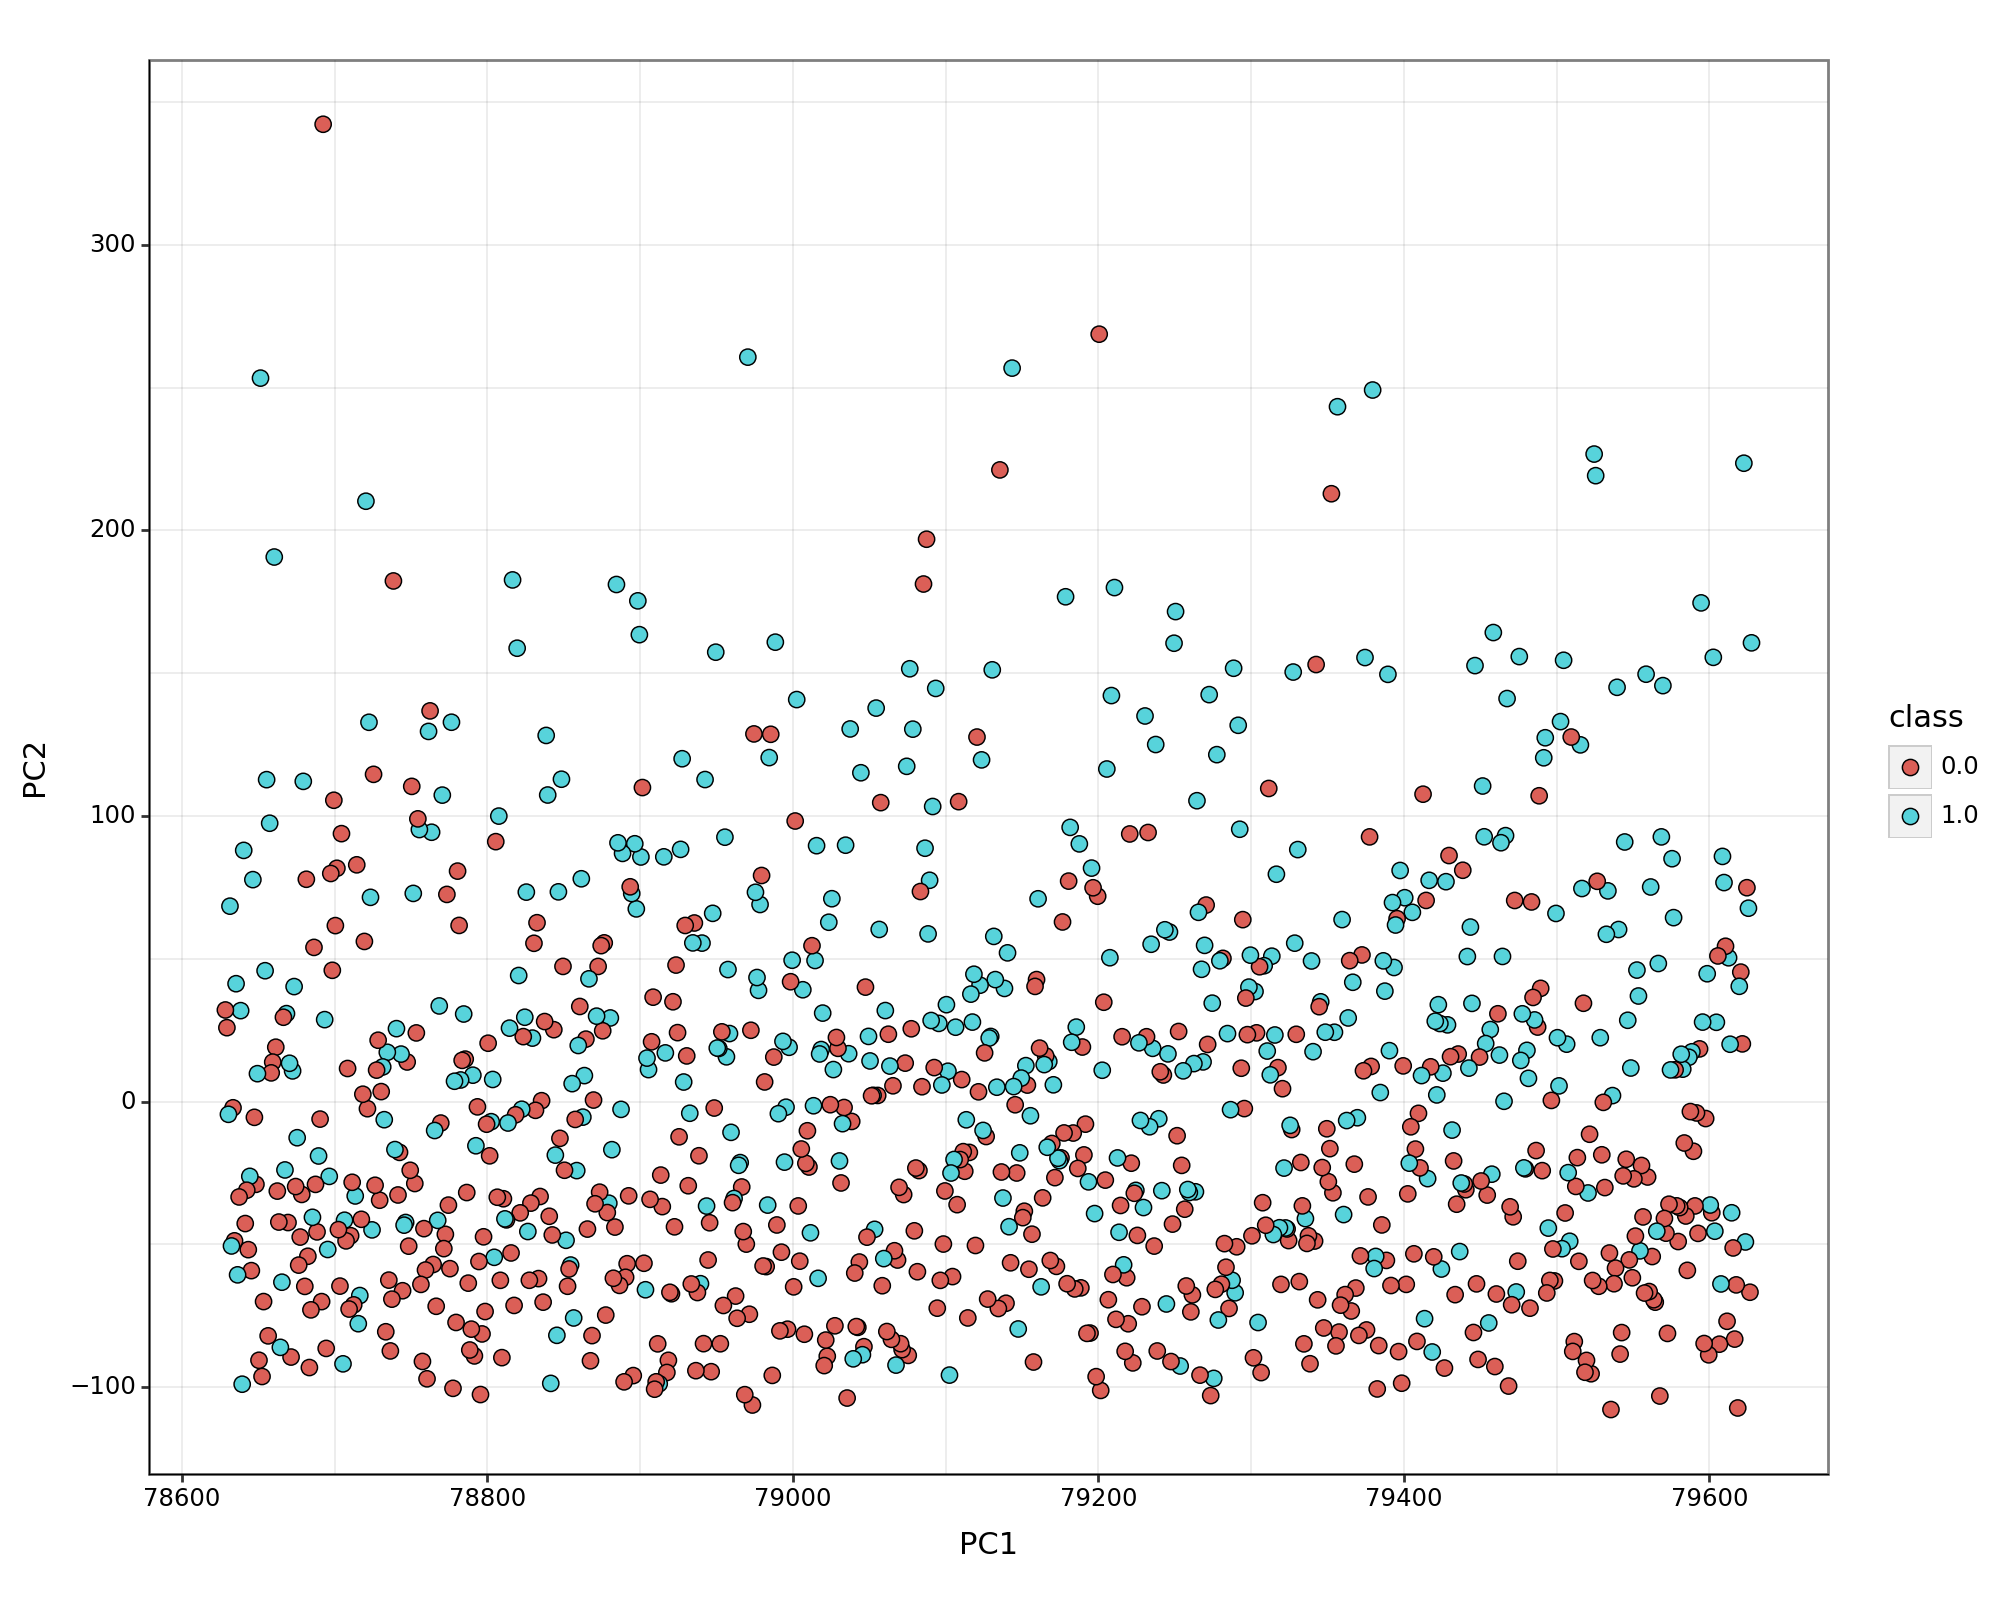

<Figure Size: (1000 x 800)>

In [ ]:
visualise_train = pd.DataFrame(train_compressed)
visualise_train.columns = [f'PC{i}' for i in np.arange(train_compressed.shape[1]) + 1]
visualise_train['class'] = train.smoking.head(1000)

visualise_train['class'] = visualise_train['class'].astype("category")
fig = (
    ggplot(data = visualise_train.head(1000),
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(aes(fill = 'class'), size = 3, shape = 'o', stroke = 0.3) +

    # All the style related codes goes here:
    labs(title ='', x = 'PC1', y = 'PC2',) +
    theme_bw() +
    theme(figure_size = (10, 8),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig